In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from config import LOOKBACK_L, HORIZON_H, TEST_SAMPLES, FEATURES, ASSUME_TZ

In [26]:
print(f"""
📊 Model Configuration
────────────────────────────
LOOKBACK_L : {LOOKBACK_L}
HORIZON_H  : {HORIZON_H}
TEST_SAMPLES: {TEST_SAMPLES}
FEATURES    : {FEATURES}
ASSUME_TZ   : {ASSUME_TZ}
────────────────────────────
""")


📊 Model Configuration
────────────────────────────
LOOKBACK_L : 48
HORIZON_H  : 3
TEST_SAMPLES: 2000
FEATURES    : ['price_pct_change', 'volume_pct_change']
ASSUME_TZ   : None
────────────────────────────



In [27]:
model = tf.keras.models.load_model("./results/models/lstm.regression.keras")

In [28]:
eth_data = pd.read_csv('./paper_wallet_data/new_eth_hourly_data.csv')
eth_data = eth_data.dropna().reset_index(drop=True)
eth_data.head()

,time,low,high,open,close,volume
0,2024-08-15 07:00:00+00:00,2589.39,2625.01,2623.84,2614.76,3283.535428
1,2024-08-15 08:00:00+00:00,2606.05,2622.11,2615.07,2621.35,1855.089703
2,2024-08-15 09:00:00+00:00,2617.40,2631.12,2621.54,2623.63,1193.382931
3,2024-08-15 10:00:00+00:00,2614.40,2627.65,2623.74,2618.11,760.890678
4,2024-08-15 11:00:00+00:00,2617.64,2643.82,2618.31,2637.94,1485.566206


In [29]:
eth_data['time'] = pd.to_datetime(eth_data['time'], utc=True)
if ASSUME_TZ is not None:
    eth_data['time'] = eth_data['time'].dt.tz_convert('UTC')

eth_data["hour"] = eth_data["time"].dt.hour

In [30]:
eth_data['price'] = eth_data['close']
eth_data['price_pct_change'] = eth_data['price'].pct_change(1)   
eth_data['volume_pct_change'] = eth_data['volume'].pct_change(1)
eth_data = eth_data.dropna().reset_index(drop=True)

eth_data = eth_data.copy()
eth_data.index = pd.to_datetime(eth_data.index, errors='raise', utc=True).tz_convert(None)

eth_data = eth_data.sort_index()

hours = eth_data['hour']
hours = np.array(hours, dtype=np.int32)   # force integers 0–23

y = eth_data['price'].pct_change(HORIZON_H)

In [31]:
#get ETH id
with open("paper_wallet_data/asset_to_id.json", "r") as f:
    asset_to_id = json.load(f)

# Example usage
eth_id = asset_to_id["ETH"]
print(f"ETH Id: {eth_id}")

ETH Id: 8


In [32]:
def make_sequences(df, L):
    X_list = []
    X = df[FEATURES].values
    X = X
    for t in range(L, len(df)):
            X_list.append(X[t-L:t,:])
    return np.stack(X_list[-TEST_SAMPLES:], dtype=np.float64)

X = make_sequences(eth_data, LOOKBACK_L)

In [33]:
def get_price_at(time):
    eth_data.loc[eth_data['time'] == time]


In [34]:
times = list(eth_data['time'].values)
prices = list(eth_data['price'].values)
volumes = list(eth_data['volume'].values)
price_pct_changes = list(eth_data['price_pct_change'].values)
volume_pct_changes = list(eth_data['volume_pct_change'].values)

In [35]:
def get_price_and_volume(time):
    try:
        idx = times.index(time)
        if len(FEATURES) == 2:
            return prices[idx], volumes[idx]
        return prices[idx]
    except ValueError:
        if len(FEATURES) == 2:
            return None, None
        return None

In [36]:
def get_model_inputs_for_time(time):
    ts = pd.Timestamp(time)
    if isinstance(times, pd.DatetimeIndex):
        # get the nearest timestamp instead of exact
        pos = times.get_indexer([ts], method='nearest')[0]
    else:
        # fallback if times is a list
        times_dt = pd.to_datetime(times)
        diffs = np.abs((times_dt - ts).total_seconds())
        pos = np.argmin(diffs)
    
    if len(FEATURES) == 2:
        return [price_pct_changes[pos], volume_pct_changes[pos]]
    return [price_pct_changes[pos]]


In [37]:
def get_prediction_inputs(current_time):
    timestamps = pd.date_range(end=current_time, periods=LOOKBACK_L+1, freq='h')[:-1]
    input = []
    for timestamp in list(timestamps):
        input.append(get_model_inputs_for_time(timestamp))
    return np.array(input).reshape(LOOKBACK_L, len(FEATURES))

In [38]:
THRESHOLD = 0.01

In [39]:
def backtest_model(model, eth_data, eth_id, HORIZON_H=HORIZON_H, LOOKBACK_L=LOOKBACK_L, TEST_SAMPLES=TEST_SAMPLES, fee=0.005):
    # Initial balances
    start_price = eth_data['price'].iloc[LOOKBACK_L]
    eth_bought = 1000.0 / start_price
    usd_balance = 0.0
    eth_balance = eth_bought

    prices = eth_data['price']
    timestamps = eth_data['time'].values

    start_idx = LOOKBACK_L

    trade_history = []

    STEP_H = HORIZON_H  # rebalance every hour
    start_idx = LOOKBACK_L
    #end_idx = min(start_idx + TEST_SAMPLES, len(timestamps) - HORIZON_H)  # ensure future exists
    end_idx = len(timestamps) - HORIZON_H  # ensure future exists


    for i in range(start_idx, end_idx, STEP_H):
        if i % 100 == 0:
            print(f"Processing step {i}/{end_idx}")
        current_time  = timestamps[i]
        current_price = prices.iloc[i]

        # inputs for now
        X = get_prediction_inputs(current_time)
        yhat = model.predict([X[np.newaxis, :, :], np.array([eth_id])], verbose=0)
        pred_change = float(yhat.squeeze()) 

        # === Trading logic ===
        if pred_change > THRESHOLD:
            # BUY ETH with 20% of USD
            trade_amt_usd = usd_balance * 0.2
            usd_balance -= trade_amt_usd
            eth_bought = (trade_amt_usd / current_price) * (1 - fee)
            eth_balance += eth_bought
            action = "BUY"
        elif pred_change < -THRESHOLD:
            # SELL 20% of ETH
            eth_sold = eth_balance * 0.2
            eth_balance -= eth_sold
            usd_balance += (eth_sold * current_price) * (1 - fee)
            action = "SELL"
        else:
            action = "HOLD"

        # Portfolio value after move
        portfolio_value = usd_balance + eth_balance * current_price

        trade_history.append({
            "time": current_time,
            "price": current_price,
            "prediction": pred_change,
            "action": action,
            "usd_balance": usd_balance,
            "eth_balance": eth_balance,
            "portfolio_value": portfolio_value
        })

    results = pd.DataFrame(trade_history).set_index("time")

    # === Baseline: HODL performance ===
    start_price = eth_data['price'].iloc[LOOKBACK_L]
    eth_bought = 1000.0 / start_price
    results["hodl_value"] = eth_bought * results["price"]

    # === Plot ===
    plt.figure(figsize=(10, 6))
    plt.plot(results.index, results["portfolio_value"], label="Model Portfolio", linewidth=2)
    plt.plot(results.index, results["hodl_value"], label="HODL ETH", linestyle="--")

    # Mark BUY and SELL points
    buy_points = results[results["action"] == "BUY"]
    sell_points = results[results["action"] == "SELL"]

    plt.scatter(buy_points.index, buy_points["portfolio_value"],
                color='blue', marker='^', s=60, label='BUY', alpha=0.8)
    plt.scatter(sell_points.index, sell_points["portfolio_value"],
                color='red', marker='v', s=60, label='SELL', alpha=0.8)

    # Labels & legend
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value (USD)")
    plt.title("Model vs HODL ETH Performance")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Return full results DataFrame for inspection
    return results

Processing step 300/9995
Processing step 600/9995
Processing step 900/9995
Processing step 1200/9995
Processing step 1500/9995
Processing step 1800/9995
Processing step 2100/9995
Processing step 2400/9995
Processing step 2700/9995
Processing step 3000/9995
Processing step 3300/9995
Processing step 3600/9995
Processing step 3900/9995
Processing step 4200/9995
Processing step 4500/9995
Processing step 4800/9995
Processing step 5100/9995
Processing step 5400/9995
Processing step 5700/9995
Processing step 6000/9995
Processing step 6300/9995
Processing step 6600/9995
Processing step 6900/9995
Processing step 7200/9995
Processing step 7500/9995
Processing step 7800/9995
Processing step 8100/9995
Processing step 8400/9995
Processing step 8700/9995
Processing step 9000/9995
Processing step 9300/9995
Processing step 9600/9995
Processing step 9900/9995


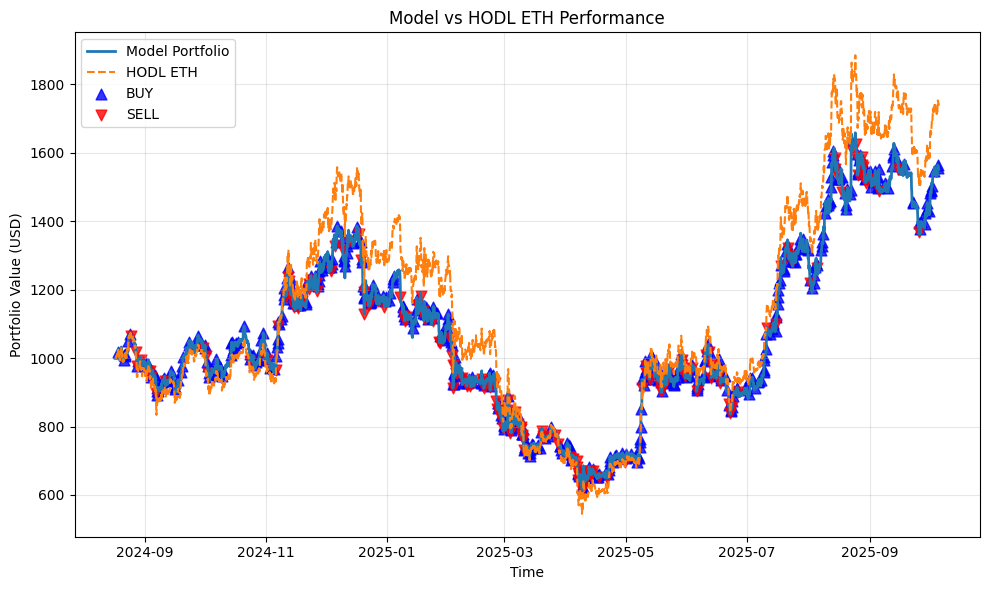

                        price  prediction action  usd_balance  eth_balance  \
time                                                                         
2025-10-05 06:00:00  4560.045    0.008690    BUY    16.245274     0.339559   
2025-10-05 09:00:00  4549.855    0.007290   HOLD    16.245274     0.339559   
2025-10-05 12:00:00  4532.975    0.002868   HOLD    16.245274     0.339559   
2025-10-05 15:00:00  4533.495    0.003190   HOLD    16.245274     0.339559   
2025-10-05 18:00:00  4520.620   -0.000174   HOLD    16.245274     0.339559   

                     portfolio_value   hodl_value  
time                                               
2025-10-05 06:00:00      1564.649247  1752.751139  
2025-10-05 09:00:00      1561.189142  1748.834394  
2025-10-05 12:00:00      1555.457387  1742.346203  
2025-10-05 15:00:00      1555.633958  1742.546077  
2025-10-05 18:00:00      1551.262137  1737.597294  


In [40]:
results = backtest_model(model, eth_data, eth_id)
print(results.tail())

In [41]:
results

,price,prediction,action,usd_balance,eth_balance,portfolio_value,hodl_value
time,,,,,,,
2024-08-17 08:00:00,2601.650,0.002453,HOLD,0.000000,0.384371,1000.000000,1000.000000
2024-08-17 11:00:00,2599.700,0.001602,HOLD,0.000000,0.384371,999.250476,999.250476
2024-08-17 14:00:00,2613.760,0.004302,HOLD,0.000000,0.384371,1004.654738,1004.654738
2024-08-17 17:00:00,2615.980,0.004446,HOLD,0.000000,0.384371,1005.508043,1005.508043
2024-08-17 20:00:00,2614.860,0.002241,HOLD,0.000000,0.384371,1005.077547,1005.077547
...,...,...,...,...,...,...,...
2025-10-05 06:00:00,4560.045,0.008690,BUY,16.245274,0.339559,1564.649247,1752.751139
2025-10-05 09:00:00,4549.855,0.007290,HOLD,16.245274,0.339559,1561.189142,1748.834394
2025-10-05 12:00:00,4532.975,0.002868,HOLD,16.245274,0.339559,1555.457387,1742.346203



📊 Prediction Statistics:
Mean:  0.002997
Std:   0.007698
Min:   -0.079475
Max:   0.092385

🟩 Buy Signals:  587 (17.70%)
   Avg Strength: 0.013566
   Max Strength: 0.092385

🟥 Sell Signals: 166 (5.01%)
   Avg Strength: -0.014517
   Min Strength: -0.079475


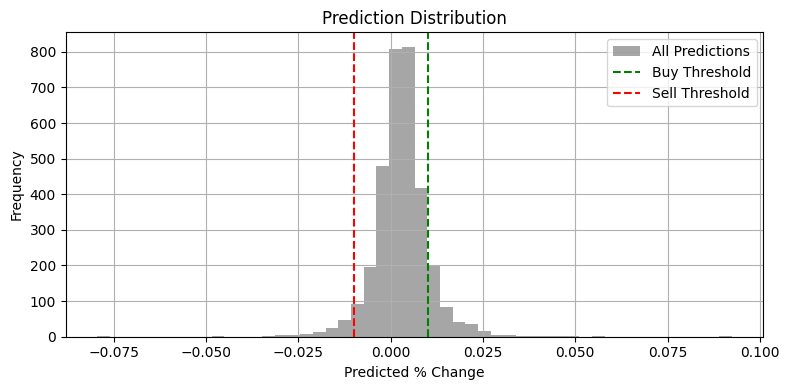

In [42]:
# === Prediction & Trade Statistics ===
pred_stats = results["prediction"].agg(["mean", "std", "min", "max"])
buy_preds = results.loc[results["prediction"] > THRESHOLD, "prediction"]
sell_preds = results.loc[results["prediction"] < -THRESHOLD, "prediction"]

print("\n📊 Prediction Statistics:")
print(f"Mean:  {pred_stats['mean']:.6f}")
print(f"Std:   {pred_stats['std']:.6f}")
print(f"Min:   {pred_stats['min']:.6f}")
print(f"Max:   {pred_stats['max']:.6f}")

print(f"\n🟩 Buy Signals:  {len(buy_preds)} ({len(buy_preds)/len(results)*100:.2f}%)")
if not buy_preds.empty:
    print(f"   Avg Strength: {buy_preds.mean():.6f}")
    print(f"   Max Strength: {buy_preds.max():.6f}")

print(f"\n🟥 Sell Signals: {len(sell_preds)} ({len(sell_preds)/len(results)*100:.2f}%)")
if not sell_preds.empty:
    print(f"   Avg Strength: {sell_preds.mean():.6f}")
    print(f"   Min Strength: {sell_preds.min():.6f}")

# Optional: quick histogram to visualize prediction spread
plt.figure(figsize=(8, 4))
plt.hist(results["prediction"], bins=50, color="gray", alpha=0.7, label="All Predictions")
plt.axvline(0.01, color="green", linestyle="--", label="Buy Threshold")
plt.axvline(-0.01, color="red", linestyle="--", label="Sell Threshold")
plt.title("Prediction Distribution")
plt.xlabel("Predicted % Change")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [43]:
# === Trading Action Statistics ===
action_counts = results["action"].value_counts()
total_trades = len(results)

num_buys = action_counts.get("BUY", 0)
num_sells = action_counts.get("SELL", 0)
num_holds = action_counts.get("HOLD", 0)

print("\n📈 Trading Summary:")
print(f"Total Steps: {total_trades}")
print(f"🟩 Buys:  {num_buys}  ({num_buys/total_trades*100:.2f}%)")
print(f"🟥 Sells: {num_sells} ({num_sells/total_trades*100:.2f}%)")
print(f"⬜ Holds: {num_holds} ({num_holds/total_trades*100:.2f}%)")


📈 Trading Summary:
Total Steps: 3316
🟩 Buys:  587  (17.70%)
🟥 Sells: 166 (5.01%)
⬜ Holds: 2563 (77.29%)


In [44]:
final_model_value = results["portfolio_value"].iloc[-1]
final_hodl_value = results["hodl_value"].iloc[-1]
print(f"Final Model Value: ${final_model_value:,.2f}")
print(f"Final HODL Value:  ${final_hodl_value:,.2f}")
print(f"Outperformance: {((final_model_value / final_hodl_value) - 1) * 100:.2f}%")

Final Model Value: $1,551.26
Final HODL Value:  $1,737.60
Outperformance: -10.72%


In [45]:
results.head()

,price,prediction,action,usd_balance,eth_balance,portfolio_value,hodl_value
time,,,,,,,
2024-08-17 08:00:00,2601.65,0.002453,HOLD,0.0,0.384371,1000.000000,1000.000000
2024-08-17 11:00:00,2599.70,0.001602,HOLD,0.0,0.384371,999.250476,999.250476
2024-08-17 14:00:00,2613.76,0.004302,HOLD,0.0,0.384371,1004.654738,1004.654738
2024-08-17 17:00:00,2615.98,0.004446,HOLD,0.0,0.384371,1005.508043,1005.508043
2024-08-17 20:00:00,2614.86,0.002241,HOLD,0.0,0.384371,1005.077547,1005.077547


In [46]:
pred_actions = results['action'].values
prices = results['price'].values

buy_predictions = 0
correct_buy_predictions = 0
sell_predictions = 0
correct_sell_predictions = 0

for i, action in enumerate(pred_actions):
    if action == 'HOLD':
        continue
    elif i + HORIZON_H >= len(prices):
        continue
    elif action == 'BUY':
        buy_predictions += 1
        if prices[i + HORIZON_H] > prices[i]:
            correct_buy_predictions += 1
    else:
        sell_predictions += 1
        if prices[i + HORIZON_H] < prices[i]:
            correct_sell_predictions += 1

print(f"Buy Predictions: {buy_predictions}, Correct: {correct_buy_predictions}, Accuracy: {correct_buy_predictions / buy_predictions if buy_predictions > 0 else 0:.2%}")
print(f"Sell Predictions: {sell_predictions}, Correct: {correct_sell_predictions}, Accuracy: {correct_sell_predictions / sell_predictions if sell_predictions > 0 else 0:.2%}")

Buy Predictions: 587, Correct: 319, Accuracy: 54.34%
Sell Predictions: 166, Correct: 91, Accuracy: 54.82%
